# Dataset Description

The dataset, 
[**Students: Germany, semester, nationality, sex, subject**](https://www-genesis.destatis.de/genesis//online?operation=table&code=21311-0003&bypass=true&levelindex=1&levelid=1714001036017#abreadcrumb), presented in this notebook provides a comprehensive overview of student statistics in Germany, detailing the number of students by semester, nationality, sex, and subject. 

## Key Features

- **Student Demographics**: The data includes a breakdown of students by gender, with separate counts for male and female students across various subjects.
- **Subject Diversity**: The dataset covers a wide range of 293 subjects, from areas like Waste Management and Egyptology to more conventional fields such as Agricultural Science and American Studies etc. and reflects the diverse academic interests pursued in Germany.
- **Semester-wise Distribution**: The statistics are organized by semester (WT 2022/23, WT 2021/22, WT 2020/21), offering insights into the enrollment trends over time.
- **Detailed Breakdown**: Each subject is listed with the total number of students, as well as the distribution between male and female students, providing a clear picture of gender representation in each academic field.

This dataset serves as a valuable resource for analyzing educational trends and gender distribution across different fields of study in Germany. It can be utilized for academic research, policy-making, and understanding the dynamics of higher education in the country.


### Importing necessary libraries

In [163]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error

### Data Loading

In [164]:
# We skip the first 7 rows and the last 3 rows as they contain dataset info but not actual data
# We also specify the column names explicitly
df = pd.read_csv('data/21311-0003_$F.csv', sep=';', encoding='ISO-8859-1', skiprows=7, skipfooter=3, engine='python',
                 names=['semester', 'subject_code', 'subject_name', 'german_male', 'german_female', 
                        'german_total', 'foreigner_male', 'foreigner_female', 'foreigner_total',
                        'male', 'female', 'total'])

### Data Cleaning

In [165]:
# In the loaded data, we replace '-' with '0' as '-' represents missing or not applicable data.
df = df.replace('-', '0')

# We fill any remaining NaN values with '0'.
df = df.fillna('0')

### Dataset Preview

In [166]:
df.head()

,semester,subject_code,subject_name,german_male,german_female,german_total,foreigner_male,foreigner_female,foreigner_total,male,female,total
0,WT 2020/21,SF141,Waste Management,53,26,79,2,0,2,55,26,81
1,WT 2020/21,SF002,African Studies,357,631,988,141,190,331,498,821,1319
2,WT 2020/21,SF138,Agricultural Biology,373,398,771,282,234,516,655,632,1287
3,WT 2020/21,SF125,Agricultural Economics,792,539,1331,359,240,599,1151,779,1930
4,WT 2020/21,SF003,Agricultural Science/Agriculture,7432,6966,14398,1143,1047,2190,8575,8013,16588


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   semester          879 non-null    object
 1   subject_code      879 non-null    object
 2   subject_name      879 non-null    object
 3   german_male       879 non-null    object
 4   german_female     879 non-null    object
 5   german_total      879 non-null    object
 6   foreigner_male    879 non-null    object
 7   foreigner_female  879 non-null    object
 8   foreigner_total   879 non-null    object
 9   male              879 non-null    object
 10  female            879 non-null    object
 11  total             879 non-null    object
dtypes: object(12)
memory usage: 82.5+ KB


## 1. What are the trends in student enrollment across various fields of study?

>**First, we group the data by 'semester' and 'subject_name', and sum the 'total' column.**

In [168]:
# This gives us the total enrollment for each subject in each semester.
enroll_trends = df.groupby(['semester', 'subject_name'])['total'].sum().reset_index()

>**We then sort the DataFrame by 'semester' and 'subject_name'.**

In [169]:
enroll_trends = enroll_trends.sort_values(['semester', 'subject_name'])

>**Next, we modify the 'semester' and 'total' column, which will be useful for plotting.**

In [170]:
#we extract the year from the 'semester' column.
enroll_trends['year'] = enroll_trends['semester'].str.extract(r'(\d{4})', expand=False)

# We then convert the 'year' column to a datetime format
enroll_trends['semester'] = pd.to_datetime(enroll_trends['year'], format='%Y')

# We also convert the 'total' column to numeric, to ensure that we can perform mathematical operations on it.
enroll_trends['total'] = pd.to_numeric(enroll_trends['total'], errors='coerce')

>**Now, we want to find out top 20 subjects have the highest total enrollments**

In [171]:
top_subjects = enroll_trends.groupby('subject_name')['total'].sum().sort_values(ascending=False).head(20).index
top_trends = enroll_trends[enroll_trends['subject_name'].isin(top_subjects)]

>**Finally, we create a line plot to visualize the enrollment trends for these top 20 subjects**

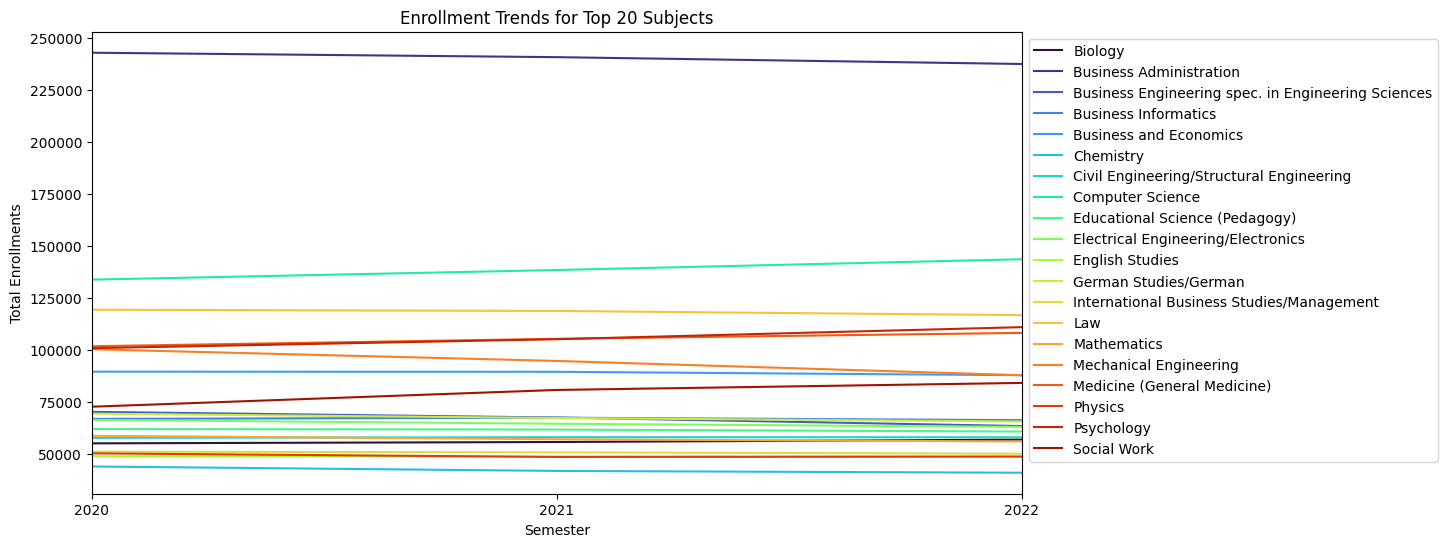

In [172]:
fig, ax = plt.subplots(figsize=(12, 6))

# We use a colormap to ensure that each subject has a different color on the plot.
cmap = matplotlib.colormaps['turbo']  
num_subjects = len(top_trends['subject_name'].unique())

for i, (subject, group) in enumerate(top_trends.groupby('subject_name')):
    color = cmap(i / num_subjects)  # Get the color from the colormap
    group.set_index('semester')['total'].plot(ax=ax, label=subject, color=color)

# We add labels and a title to the plot.
ax.set_xlabel('Semester')
ax.set_ylabel('Total Enrollments')
ax.set_title('Enrollment Trends for Top 20 Subjects')

# We place the legend outside of the plot on the right side.
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Finally, we display the plot.
plt.show()

**The line graph shows the changes in enrollment numbers for various academic subjects over three years. 
Each line represents a different subject, with distinct colors for easy differentiation. 
The graph indicates the popularity of top 20 subjects by displaying their enrollment figures over time. 
The y-axis measures the number of enrollments, which range up to 250,000, 
while the x-axis represents the years that represents the semester WT 2020/21, WT 2021/22, and WT 2022/23 respectively.
This visual representation helps to identify the trend of which subjects are gaining or losing popularity among students.**

## 2. How does gender distribution vary across different fields of study?

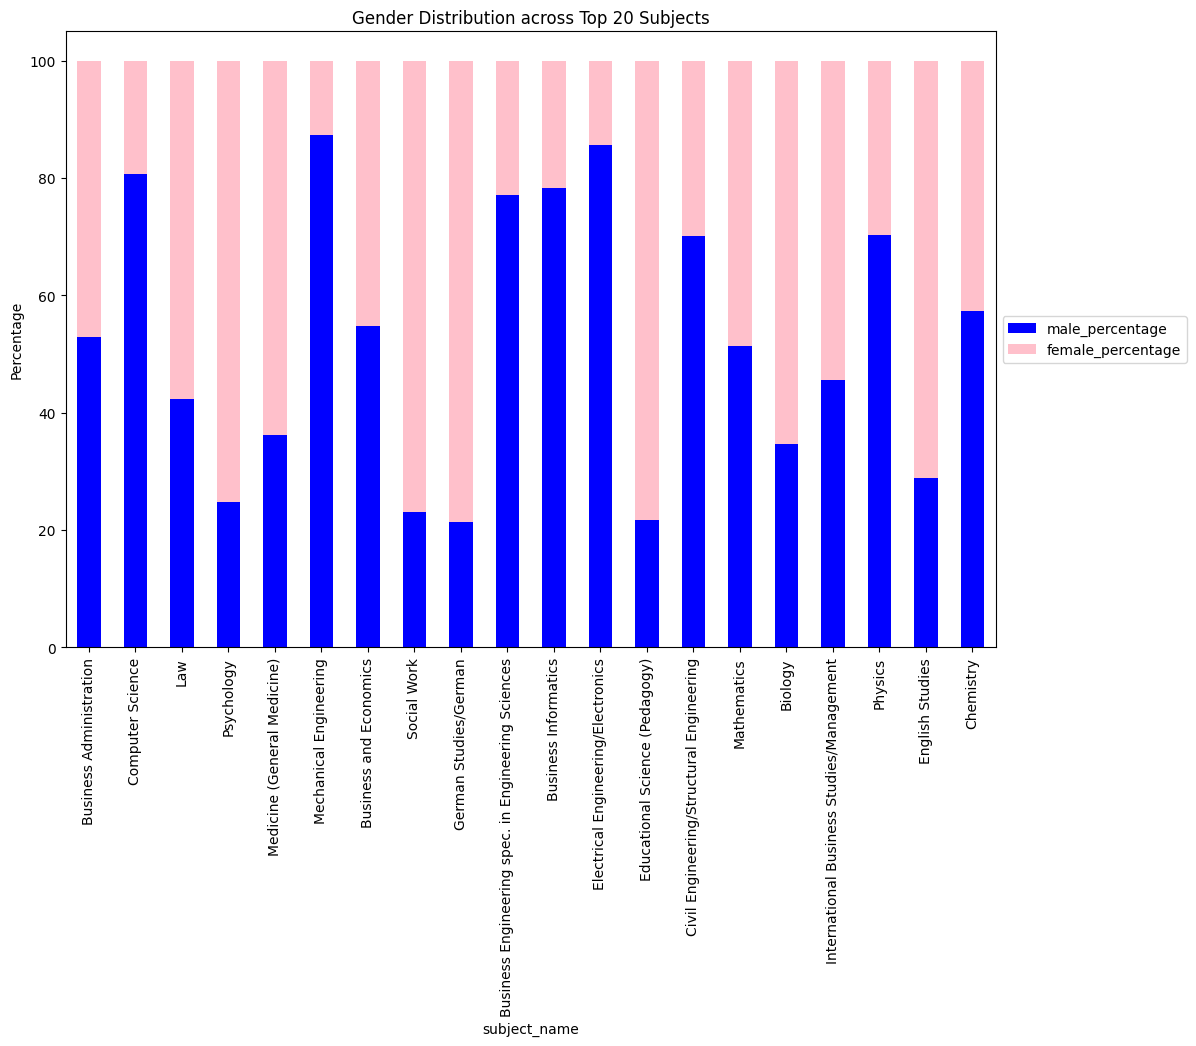

In [173]:
# Converting the column into integer, so that we can perform mathematical operations
df['male'] = df['male'].astype(int)
df['female'] = df['female'].astype(int)
df['total'] = df['total'].astype(int)

# Group by 'subject_name'
grouped = df.groupby('subject_name').sum()

# Calculate percentage male/female for each subject
grouped['male_percentage'] = grouped['male'] / grouped['total'] * 100
grouped['female_percentage'] = grouped['female'] / grouped['total'] * 100

# Sort the grouped data by 'total' in descending order and take the top 20
top_10_subjects = grouped.sort_values(by='total', ascending=False).head(20)

# Visualize with a bar chart for the top 20 subjects
ax = top_10_subjects[['male_percentage', 'female_percentage']].plot(kind='bar', stacked=True, figsize=(12, 8), color=['blue', 'pink'])
plt.ylabel('Percentage')
plt.title('Gender Distribution across Top 20 Subjects')

# Place legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()


**The bar chart illustrates the percentage of male and female students enrolled in the top 20 subjects. The chart uses blue bars to represent male percentages and pink bars for female percentages. The subjects are listed along the horizontal axis, and the vertical axis indicates the percentage, ranging from 0 to 100%. Given that there are 293 subjects in total, this chart simplifies the data by focusing on the top 20 subjects with the highest enrollment numbers, providing a clearer picture of gender distribution in the most popular fields**.

## 3. Show the distribution of students across top 10 subjects

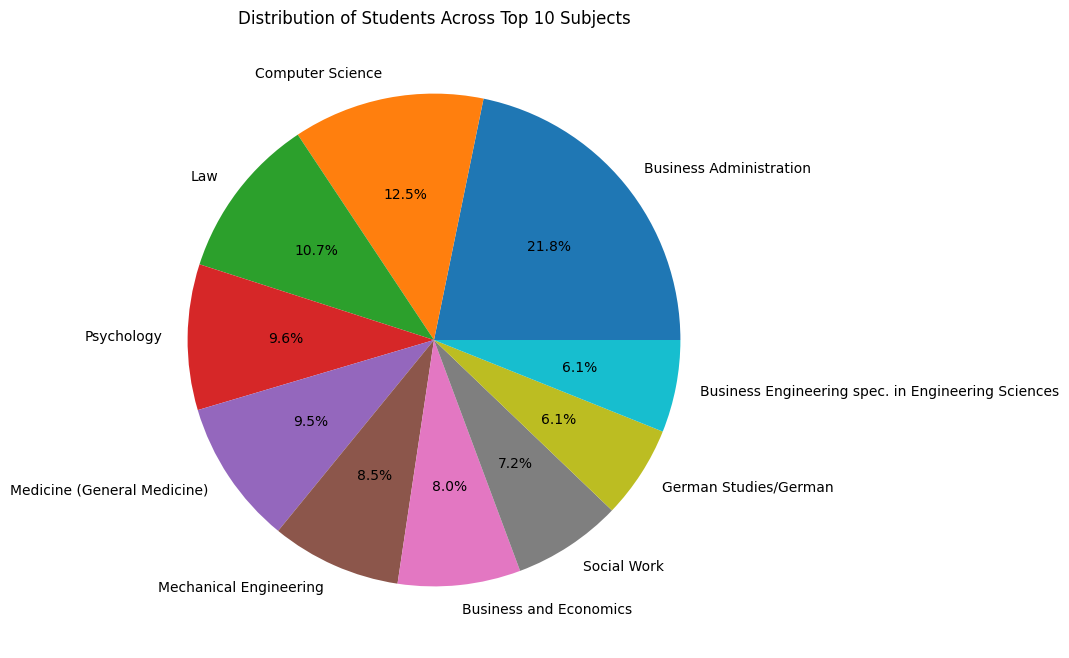

In [174]:
# Group by 'subject_name' and sum 'total'
grouped = df.groupby('subject_name')['total'].sum()

# Sort the grouped data in descending order
sorted_grouped = grouped.sort_values(ascending=False)

# Take the top 10 subjects
top_10_subjects = sorted_grouped.head(10)

# Plot a pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_10_subjects, labels=top_10_subjects.index, autopct='%1.1f%%')
plt.title('Distribution of Students Across Top 10 Subjects')
plt.show()

**The pie chart visually represents the proportion of students enrolled in the top 10 academic subjects. The largest segment is “Business and Economics” at 21.8%, indicating a significant interest in this field. “Law” and “Computer Science” follow with 12.5% and 10.7% respectively, showcasing their popularity among students. Since the total number of subjects is 293, this chart focuses on the top 10 to provide a clear and concise overview of where the majority of students are concentrating their studies.**


## 4. Which subject is most popular among international students?

In [175]:
# Convert 'foreigner_total' to integer
#df['foreigner_total'] = df['foreigner_total'].astype(int)

# Group by 'subject_name' and sum 'foreigner_total'
grouped = df.groupby('subject_name')['foreigner_total'].sum()

# Find the subject with the maximum 'foreigner_total'
most_popular_subject = grouped.idxmax()

print(f"The most popular subject for international students is: {most_popular_subject}")

The most popular subject for international students is: Medical Informatics


## 5. Which subjects are most popular among male versus female students?

In [176]:
# Group by 'subject_name' and sum 'male' and 'female'
grouped = df.groupby('subject_name').agg({'male': 'sum', 'female': 'sum'})

# Sort by 'male' and 'female' and get top 10
top_male_subjects = grouped['male'].sort_values(ascending=False).head(10)
top_female_subjects = grouped['female'].sort_values(ascending=False).head(10)

>#### Top 10 subjects for male students:

In [177]:
top_male_subjects_df = top_male_subjects.to_frame()
display(top_male_subjects_df)

,male
subject_name,
Business Administration,381421
Computer Science,335771
Mechanical Engineering,247008
Electrical Engineering/Electronics,165603
Business Informatics,156789
Business Engineering spec. in Engineering Sciences,154811
Law,149964
Business and Economics,146236
Civil Engineering/Structural Engineering,121697


>#### Top 10 subjects for female students:

In [178]:
top_female_subjects_df = top_female_subjects.to_frame()
display(top_female_subjects_df)

,female
subject_name,
Business Administration,340026
Psychology,238458
Law,204689
Medicine (General Medicine),201007
Social Work,182426
German Studies/German,158854
Educational Science (Pedagogy),144155
Business and Economics,120396
Biology,109388


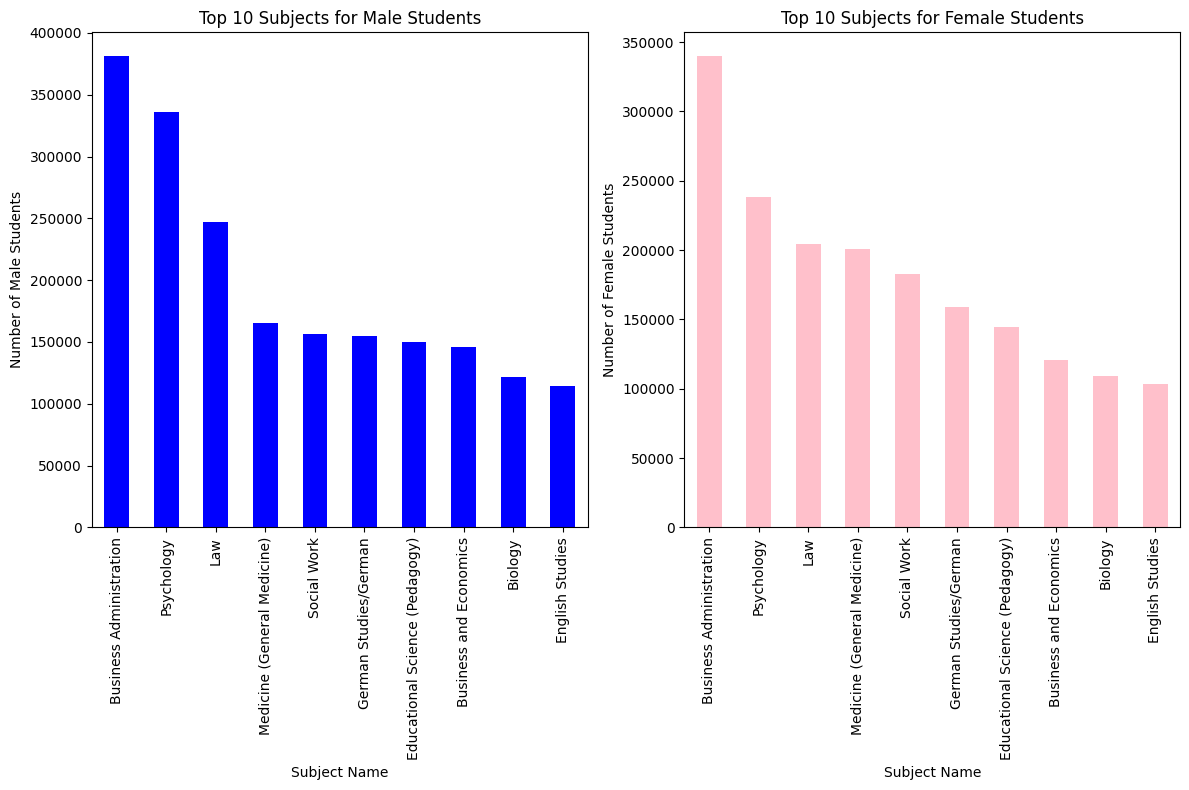

In [179]:
# Create plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharex=True)

top_male_subjects.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 10 Subjects for Male Students')
axes[0].set_ylabel('Number of Male Students')
axes[0].set_xlabel('Subject Name')

top_female_subjects.plot(kind='bar', ax=axes[1], color='pink')
axes[1].set_title('Top 10 Subjects for Female Students')
axes[1].set_ylabel('Number of Female Students')
axes[1].set_xlabel('Subject Name')

plt.tight_layout()
plt.show()